# TESS Atlas fit for TOI 214

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 214.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-214.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-214.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-214.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 214

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
has_r_star = True

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    toi_r_star = 1.0
    toi_r_star_err = 0.0
    has_r_star = False

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 214 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

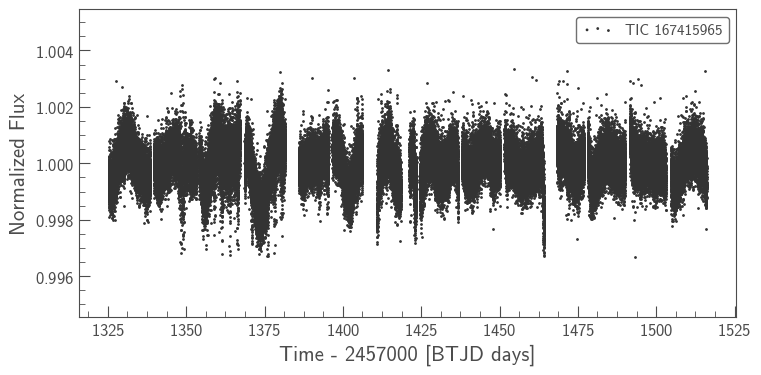

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()

# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -113796.2340920082 -> -94638.73437209381


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean flux of the star,
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -93380.85294973972 -> -83124.92558237746


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -83124.92558237746 -> -83091.27897858966


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -83091.27897858966 -> -83089.78603728463


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -83089.78603728463 -> -83089.47173708414


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Optimization terminated successfully.
logp: -83089.47173708414 -> -83088.79715432075


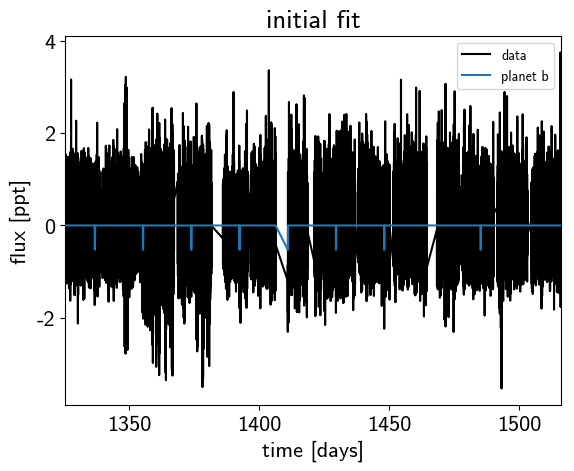

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2)
    trace = sampler.sample(draws=1000, chains=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 80.95draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:12,  7.25draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:28,  3.21draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:37,  2.32draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:05<01:01,  1.42draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:07<00:59,  1.42draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:08<01:00,  1.37draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:10<01:02,  1.30draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:11<00:58,  1.34draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:13<00:58,  1.32draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:14<00:56,  1.33draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:16<00:54,  1.34draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:17<00:53,  1.33draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:19<00:53,  1.30draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:20<00:51,  1.31draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:22<00:47,  1.36draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:23<00:45,  1.38draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:24<00:43,  1.41draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:26<00:41,  1.42draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:27<00:39,  1.46draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:28<00:37,  1.46draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:30<00:35,  1.48draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:31<00:34,  1.49draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:32<00:32,  1.50draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:34<00:31,  1.49draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:35<00:29,  1.52draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:36<00:23,  1.87draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:36<00:25,  1.64draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:37<00:23,  1.73draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:38<00:25,  1.58draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:38<00:23,  1.68draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:39<00:25,  1.52draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:39<00:22,  1.63draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:40<00:24,  1.49draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:41<00:21,  1.62draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:41<00:22,  1.51draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:42<00:20,  1.64draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:43<00:21,  1.48draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:43<00:20,  1.53draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:44<00:21,  1.40draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:45<00:18,  1.54draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:46<00:19,  1.44draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:46<00:16,  1.62draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:47<00:18,  1.41draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:47<00:15,  1.60draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:48<00:16,  1.44draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:49<00:14,  1.61draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:50<00:15,  1.43draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:50<00:12,  1.62draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:51<00:14,  1.41draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:51<00:11,  1.59draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:52<00:12,  1.42draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:53<00:10,  1.56draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:54<00:11,  1.41draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:54<00:09,  1.51draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:55<00:11,  1.22draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:56<00:09,  1.38draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:57<00:09,  1.31draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:57<00:07,  1.38draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:58<00:07,  1.30draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:59<00:05,  1.50draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [01:00<00:05,  1.34draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [01:00<00:04,  1.42draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:01<00:05,  1.19draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [01:02<00:03,  1.33draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [01:03<00:03,  1.17draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:04<00:02,  1.29draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:05<00:01,  1.20draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:09<00:01,  1.94s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:10<00:00,  1.62s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:00, 95.48draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:03<00:27,  3.29draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:35,  2.50draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:06<00:45,  1.90draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:08<00:50,  1.65draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:08<00:46,  1.77draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:09<00:53,  1.54draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:09<00:47,  1.71draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:10<00:52,  1.52draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:11<00:46,  1.69draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:11<00:45,  1.71draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:12<00:38,  2.02draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:13<00:50,  1.49draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:13<00:41,  1.82draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:14<00:53,  1.39draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:14<00:43,  1.67draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:15<00:54,  1.32draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:16<00:43,  1.64draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:17<00:53,  1.30draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:17<00:42,  1.62draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:18<00:57,  1.18draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:19<00:46,  1.45draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:19<00:36,  1.82draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:20<00:38,  1.68draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:21<00:43,  1.48draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:21<00:42,  1.48draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:22<00:41,  1.50draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:23<00:40,  1.50draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:23<00:41,  1.46draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:24<00:39,  1.49draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:25<00:39,  1.48draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:25<00:38,  1.49draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:26<00:37,  1.50draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:26<00:30,  1.78draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:27<00:26,  2.03draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:28<00:33,  1.57draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:28<00:28,  1.83draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:29<00:35,  1.44draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:29<00:29,  1.70draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:30<00:34,  1.40draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:31<00:28,  1.69draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:32<00:34,  1.36draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:32<00:28,  1.62draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:33<00:33,  1.36draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:33<00:26,  1.67draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:35<00:26,  1.59draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:36<00:25,  1.60draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:37<00:21,  1.75draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:38<00:19,  1.78draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:39<00:15,  2.23draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:40<00:21,  1.57draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:40<00:16,  1.98draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:41<00:20,  1.49draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:41<00:15,  1.91draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:42<00:19,  1.45draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:42<00:14,  1.87draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:43<00:18,  1.43draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:44<00:14,  1.86draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:45<00:17,  1.40draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:45<00:13,  1.80draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:46<00:16,  1.37draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:46<00:12,  1.78draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:47<00:11,  1.77draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:48<00:08,  2.12draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:49<00:11,  1.59draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:49<00:09,  1.89draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:50<00:10,  1.48draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:50<00:08,  1.83draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:51<00:09,  1.44draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:51<00:07,  1.79draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:52<00:07,  1.59draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:52<00:05,  1.95draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:53<00:04,  2.05draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:53<00:04,  1.89draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:54<00:04,  1.69draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:55<00:04,  1.68draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:56<00:03,  1.61draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:56<00:03,  1.65draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:57<00:02,  1.61draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:58<00:02,  1.22draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:59<00:01,  1.02draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:01<00:01,  1.27s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:02<00:00,  1.08s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:01<04:28,  1.32s/draws]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<03:11,  1.04draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<03:19,  1.00s/draws]

Sampling 2 chains:   3%|▎         | 6/204 [00:03<02:33,  1.29draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:03<02:13,  1.47draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<02:04,  1.58draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:04<02:07,  1.52draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:05<02:00,  1.61draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:06<02:10,  1.48draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:06<02:05,  1.53draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:07<02:09,  1.48draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:08<01:48,  1.75draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:08<02:09,  1.45draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:09<02:03,  1.51draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:10<02:11,  1.41draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:10<02:01,  1.53draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:11<01:33,  1.97draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:11<01:11,  2.55draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:11<01:02,  2.91draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:12<00:53,  3.34draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:13<01:29,  1.99draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:13<01:24,  2.10draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:14<01:43,  1.70draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:14<01:32,  1.90draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:15<01:50,  1.58draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:15<01:35,  1.80draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:16<01:52,  1.54draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:17<01:36,  1.76draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:17<01:46,  1.59draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:18<01:25,  1.98draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:18<01:22,  2.04draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:19<01:38,  1.69draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:19<01:32,  1.80draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:20<01:13,  2.25draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:21<01:44,  1.57draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:21<01:15,  2.16draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:21<01:06,  2.41draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:22<01:17,  2.06draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:22<00:56,  2.76draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:23<01:07,  2.28draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:24<00:54,  2.84draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:24<01:02,  2.45draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:25<01:16,  1.99draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:26<01:21,  1.85draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:26<01:03,  2.34draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:27<00:58,  2.51draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:28<01:12,  2.02draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:28<01:06,  2.18draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:28<01:06,  2.17draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:29<00:52,  2.72draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:29<00:49,  2.84draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:30<01:18,  1.79draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:32<01:25,  1.61draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:33<01:25,  1.59draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:33<01:05,  2.06draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:34<01:16,  1.74draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:34<00:55,  2.35draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:35<01:22,  1.57draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:35<01:03,  2.04draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:37<01:27,  1.46draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:37<01:06,  1.90draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:38<01:28,  1.42draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:38<01:07,  1.86draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:38<00:52,  2.36draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:39<00:53,  2.29draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:39<00:50,  2.39draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:40<00:43,  2.75draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:40<00:46,  2.55draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:41<00:59,  1.97draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:41<01:00,  1.92draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:42<00:50,  2.28draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:42<00:57,  2.00draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:43<01:06,  1.71draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:44<00:55,  2.03draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:44<00:50,  2.18draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:45<00:53,  2.03draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:46<01:02,  1.74draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:46<01:00,  1.78draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:47<01:04,  1.63draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:48<01:03,  1.66draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:48<00:54,  1.92draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:48<00:49,  2.07draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:49<01:01,  1.67draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:50<00:54,  1.84draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:51<01:05,  1.53draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:51<00:50,  1.93draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:52<01:02,  1.55draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:53<01:01,  1.54draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:54<00:51,  1.81draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:54<00:40,  2.29draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:54<00:40,  2.26draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:55<00:32,  2.75draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:55<00:29,  2.97draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:55<00:21,  3.96draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:56<00:42,  1.98draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:56<00:34,  2.45draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:57<00:39,  2.10draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:57<00:39,  2.10draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:58<00:47,  1.71draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:59<00:40,  2.00draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:59<00:30,  2.56draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:59<00:28,  2.73draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:59<00:25,  3.07draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [01:00<00:22,  3.37draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [01:00<00:16,  4.42draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [01:01<00:37,  1.91draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [01:02<00:35,  1.99draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [01:02<00:30,  2.23draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [01:03<00:28,  2.32draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [01:03<00:22,  2.97draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [01:04<00:18,  3.39draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [01:04<00:14,  4.32draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [01:05<00:30,  2.00draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [01:05<00:24,  2.44draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [01:06<00:35,  1.65draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [01:06<00:27,  2.09draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [01:08<00:29,  1.88draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [01:08<00:21,  2.54draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [01:08<00:17,  3.03draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:09<00:20,  2.49draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:09<00:22,  2.27draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:10<00:26,  1.88draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:10<00:21,  2.26draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:11<00:15,  2.84draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:11<00:19,  2.28draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:12<00:21,  2.02draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:13<00:21,  1.86draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:13<00:15,  2.55draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:14<00:14,  2.58draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:14<00:10,  3.33draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:15<00:09,  3.57draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:15<00:09,  3.46draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:16<00:12,  2.43draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:16<00:13,  2.20draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:17<00:10,  2.75draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:17<00:07,  3.49draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:17<00:06,  3.84draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:18<00:10,  2.10draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:19<00:08,  2.49draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:19<00:06,  3.29draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:19<00:04,  3.87draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:20<00:09,  1.98draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:20<00:06,  2.51draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:21<00:09,  1.66draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:21<00:06,  2.15draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:21<00:04,  2.91draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:22<00:04,  2.58draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:23<00:07,  1.52draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:24<00:08,  1.17draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:25<00:05,  1.55draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:26<00:06,  1.21draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:26<00:05,  1.36draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:27<00:04,  1.39draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:28<00:04,  1.18draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:29<00:01,  1.61draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:29<00:00,  2.04draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:29<00:00,  2.28draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/404 [00:00<00:33, 12.10draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:27, 14.46draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:30, 12.98draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:28, 13.77draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:24, 16.04draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:21, 18.10draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<00:19, 19.68draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:01<00:16, 22.54draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:14, 25.59draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:15, 24.50draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:15, 23.51draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:15, 23.23draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:16, 21.67draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:14, 25.10draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:02<00:15, 23.20draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:02<00:16, 20.83draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:02<00:16, 21.59draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:02<00:15, 22.51draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:02<00:13, 26.22draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:02<00:11, 28.18draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:03<00:13, 25.32draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:12, 25.97draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:03<00:12, 25.56draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:03<00:12, 25.78draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:03<00:13, 23.44draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:03<00:14, 22.33draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:03<00:15, 20.69draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:04<00:15, 19.50draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:04<00:15, 19.41draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:04<00:14, 20.80draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:04<00:13, 21.63draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:04<00:12, 23.34draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:04<00:11, 26.20draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:04<00:10, 27.66draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:04<00:09, 28.90draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:05<00:10, 26.68draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:05<00:10, 26.64draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:05<00:09, 28.20draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:05<00:09, 27.50draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:05<00:09, 27.05draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:05<00:12, 21.97draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:05<00:11, 22.84draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:06<00:09, 27.15draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:06<00:08, 28.94draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:06<00:09, 27.45draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:06<00:08, 29.54draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:06<00:09, 24.28draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:06<00:11, 20.67draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:06<00:10, 22.08draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:07<00:09, 23.16draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:07<00:09, 23.96draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:07<00:09, 24.52draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:07<00:08, 24.86draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:07<00:10, 20.96draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:07<00:09, 22.28draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:07<00:09, 23.47draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:08<00:08, 25.69draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:08<00:07, 26.16draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:08<00:06, 30.50draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:08<00:05, 33.61draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:08<00:05, 35.94draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:08<00:05, 31.54draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:08<00:05, 32.20draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:08<00:06, 29.35draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:09<00:06, 28.34draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:09<00:06, 25.06draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:09<00:07, 23.07draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:09<00:06, 25.13draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:09<00:05, 26.88draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:09<00:05, 29.48draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:09<00:04, 30.22draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:10<00:04, 31.62draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:10<00:04, 29.79draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:10<00:04, 31.16draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:10<00:04, 31.42draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:10<00:04, 32.38draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:10<00:04, 27.76draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:10<00:04, 27.61draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:10<00:04, 28.46draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:11<00:03, 28.95draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:11<00:04, 25.26draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:11<00:04, 25.61draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:11<00:03, 26.67draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:11<00:03, 26.01draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:11<00:03, 27.76draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:12<00:03, 26.88draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:12<00:03, 28.38draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:12<00:03, 26.47draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:12<00:02, 28.14draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:12<00:02, 30.00draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:12<00:02, 34.03draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:12<00:02, 32.42draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:12<00:02, 29.67draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:13<00:02, 25.93draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:13<00:02, 25.51draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:13<00:02, 24.59draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:13<00:02, 22.41draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:13<00:02, 20.79draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:13<00:02, 20.13draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:13<00:01, 21.69draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:14<00:01, 20.61draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:14<00:01, 23.63draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:14<00:01, 23.90draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:14<00:01, 23.11draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:14<00:01, 21.64draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:14<00:00, 24.34draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:14<00:00, 24.46draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:15<00:00, 28.02draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:15<00:00, 27.54draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:15<00:00, 21.09draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:15<00:00, 19.63draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:15<00:00, 25.64draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:27, 28.76draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:31, 24.96draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:48, 16.42draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:45, 17.30draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:38, 20.36draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:32, 24.23draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:28, 27.51draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:01<00:24, 31.50draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:01<00:26, 29.23draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:01<00:26, 28.75draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:34, 21.80draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:01<00:33, 22.39draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:01<00:37, 20.42draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:02<00:32, 23.10draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:02<00:27, 27.53draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:02<00:23, 31.94draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:02<00:22, 32.14draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:02<00:24, 29.65draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:02<00:23, 30.93draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:02<00:23, 31.23draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:02<00:22, 31.94draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:03<00:22, 31.93draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:24, 29.47draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:03<00:20, 33.68draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:03<00:19, 35.88draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:03<00:22, 31.53draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:03<00:23, 29.34draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:03<00:23, 29.75draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:04<00:22, 30.26draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:04<00:24, 27.36draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:04<00:21, 31.66draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:04<00:19, 33.92draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:04<00:18, 35.49draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:04<00:18, 36.51draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:04<00:20, 32.19draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:04<00:18, 34.38draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:05<00:21, 30.89draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:05<00:20, 31.27draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:05<00:22, 28.77draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:05<00:21, 29.86draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:05<00:20, 31.48draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:05<00:18, 33.62draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:05<00:17, 36.06draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:06<00:17, 35.49draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:06<00:16, 37.03draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:06<00:17, 35.89draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:06<00:15, 38.10draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:06<00:16, 37.07draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:06<00:16, 36.12draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:06<00:15, 39.15draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:06<00:13, 42.41draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:07<00:15, 37.24draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:07<00:15, 36.53draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:07<00:15, 35.93draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:07<00:13, 40.43draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:07<00:14, 39.73draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:07<00:13, 40.78draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:07<00:13, 41.44draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:07<00:14, 38.31draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:07<00:13, 41.49draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:08<00:12, 42.02draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:08<00:12, 41.04draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:08<00:12, 41.60draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:08<00:12, 41.92draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:08<00:12, 40.49draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:08<00:14, 34.75draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:08<00:14, 33.99draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:09<00:17, 29.01draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:09<00:16, 30.39draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:09<00:14, 32.95draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:09<00:14, 34.34draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:09<00:13, 35.27draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:09<00:13, 36.12draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:09<00:13, 36.54draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:09<00:12, 38.14draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:10<00:11, 41.31draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:10<00:11, 41.73draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:10<00:10, 43.57draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:10<00:10, 42.35draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:10<00:10, 42.38draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:10<00:11, 39.72draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:10<00:10, 40.60draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:10<00:10, 42.18draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:10<00:10, 42.39draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:11<00:09, 42.27draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:11<00:09, 42.82draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:11<00:09, 42.29draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:11<00:10, 39.74draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:11<00:10, 38.96draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:11<00:09, 41.26draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:11<00:09, 41.45draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:11<00:09, 38.83draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:12<00:13, 27.95draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:12<00:14, 25.48draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:12<00:13, 27.15draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:12<00:12, 29.73draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:12<00:11, 31.87draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:12<00:11, 31.53draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:13<00:12, 29.51draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:13<00:12, 27.99draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:13<00:10, 32.24draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:13<00:09, 35.32draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:13<00:08, 39.13draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:13<00:08, 40.33draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:13<00:07, 40.68draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:13<00:07, 40.90draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:14<00:07, 41.39draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:14<00:07, 41.59draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:14<00:08, 37.00draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:14<00:08, 36.43draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:14<00:07, 38.37draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:14<00:07, 38.67draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:14<00:08, 35.08draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:14<00:08, 34.46draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:15<00:07, 37.59draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:15<00:06, 40.42draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:15<00:06, 43.19draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:15<00:06, 40.95draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:15<00:06, 41.91draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:15<00:05, 42.57draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:15<00:05, 44.80draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:15<00:05, 43.79draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:16<00:05, 41.45draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:16<00:05, 37.96draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:16<00:05, 39.31draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:16<00:05, 36.91draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:16<00:05, 36.16draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:16<00:05, 35.51draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:16<00:05, 37.36draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:16<00:05, 38.75draws/s]

Sampling 2 chains:  76%|███████▌  | 610/804 [00:17<00:04, 39.71draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:17<00:05, 36.93draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:17<00:05, 36.29draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:17<00:04, 38.16draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:17<00:04, 41.41draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:17<00:03, 44.02draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:17<00:03, 46.11draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:18<00:03, 41.02draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:18<00:03, 42.88draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:18<00:04, 32.83draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:18<00:03, 35.79draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:18<00:03, 37.71draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:18<00:03, 41.04draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:18<00:03, 41.33draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:18<00:02, 43.58draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:19<00:03, 36.90draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:19<00:03, 34.66draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:19<00:03, 34.76draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:19<00:02, 35.99draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:19<00:02, 32.47draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:19<00:03, 28.76draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:19<00:03, 29.39draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [00:20<00:02, 30.62draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:20<00:02, 28.02draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:20<00:02, 27.55draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:20<00:02, 28.48draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:20<00:02, 25.04draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:20<00:02, 29.23draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:20<00:02, 28.05draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:21<00:02, 27.09draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:21<00:02, 26.26draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:21<00:01, 28.09draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [00:21<00:01, 29.90draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:21<00:01, 32.72draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:21<00:00, 36.46draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:21<00:00, 35.88draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:21<00:00, 37.52draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:22<00:00, 35.44draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:22<00:00, 38.70draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:22<00:00, 40.06draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [00:22<00:00, 40.75draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:22<00:00, 27.67draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<10:44,  6.83draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<08:14,  8.90draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<06:42, 10.92draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<05:26, 13.44draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<04:30, 16.23draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<03:55, 18.58draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:00<03:28, 21.03draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<03:04, 23.68draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<02:55, 24.91draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<03:56, 18.48draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<03:36, 20.21draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:01<03:30, 20.70draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:01<03:19, 21.86draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:02<02:59, 24.31draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<02:38, 27.51draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:02<02:22, 30.50draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:02<02:33, 28.27draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:02<02:57, 24.39draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<02:48, 25.65draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:02<02:36, 27.65draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:03<02:40, 26.89draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:03<02:32, 28.40draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:03<02:22, 30.32draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:03<02:29, 28.85draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:03<02:12, 32.64draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:03<02:22, 30.21draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:03<02:30, 28.56draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:03<02:23, 30.02draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:04<02:53, 24.72draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<02:51, 24.94draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:04<02:26, 29.24draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:04<02:32, 28.11draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:04<02:38, 26.99draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:04<02:47, 25.48draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:04<02:29, 28.50draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:05<02:21, 30.05draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:05<02:20, 30.41draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:05<02:18, 30.73draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:05<02:13, 31.95draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:05<02:10, 32.64draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:05<02:03, 34.32draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:05<02:15, 31.41draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:05<02:15, 31.21draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:06<02:28, 28.45draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:06<02:46, 25.48draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:06<02:33, 27.59draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:06<02:21, 29.85draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:06<02:16, 30.97draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:06<02:12, 31.71draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:06<01:57, 35.76draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:07<01:51, 37.62draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:07<02:13, 31.32draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:07<02:13, 31.32draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:07<02:09, 32.38draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:07<02:08, 32.50draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:07<02:20, 29.80draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:07<02:23, 29.02draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:07<02:09, 32.22draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:08<02:16, 30.61draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:08<02:22, 29.29draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:08<02:04, 33.29draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:08<02:04, 33.32draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:08<02:03, 33.56draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:08<02:00, 34.46draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:08<02:00, 34.28draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:08<01:48, 38.08draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:09<01:45, 39.19draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:09<01:40, 41.07draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:09<01:43, 39.96draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:09<01:48, 37.90draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:09<01:55, 35.70draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:09<02:00, 33.97draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:09<01:49, 37.30draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:10<01:52, 36.43draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:10<01:48, 37.66draws/s]

Sampling 2 chains:   7%|▋         | 316/4404 [00:10<01:48, 37.80draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:10<01:46, 38.26draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:10<01:46, 38.24draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:10<01:39, 40.90draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:10<01:38, 41.31draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:10<01:40, 40.28draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:10<01:35, 42.53draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:11<01:46, 38.21draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:11<01:46, 37.98draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:11<01:43, 39.06draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:11<01:50, 36.54draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:11<01:50, 36.45draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:11<01:50, 36.54draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:11<01:45, 38.31draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:11<01:46, 37.69draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:12<02:02, 32.71draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:12<02:04, 32.32draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:12<01:52, 35.63draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [00:12<01:54, 35.03draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:12<01:52, 35.60draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:12<01:49, 36.55draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:12<01:50, 35.97draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:12<01:52, 35.58draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:13<01:46, 37.57draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:13<01:43, 38.38draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:13<01:35, 41.59draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:13<01:31, 43.26draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:13<01:24, 47.00draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:13<01:26, 45.55draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:13<01:31, 43.38draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:13<01:31, 43.28draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:14<01:59, 33.08draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:14<01:57, 33.55draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:14<02:08, 30.72draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:14<01:56, 33.61draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:14<02:06, 30.92draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:14<02:06, 30.91draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:14<01:52, 34.81draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:15<01:52, 34.76draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:15<02:01, 32.05draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:15<02:04, 31.37draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:15<02:00, 32.35draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:15<01:57, 33.02draws/s]

Sampling 2 chains:  12%|█▏        | 514/4404 [00:15<01:56, 33.42draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:15<01:47, 36.17draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:15<01:44, 37.12draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:15<01:35, 40.51draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:16<01:32, 42.04draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:16<01:34, 41.09draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:16<01:29, 43.27draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:16<01:31, 42.26draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:16<01:30, 42.60draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:16<01:29, 42.74draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:16<01:27, 43.71draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:16<01:24, 45.56draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:17<01:28, 43.39draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:17<01:24, 45.19draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:17<01:21, 46.88draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:17<01:23, 45.57draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:17<01:37, 39.18draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:17<01:50, 34.54draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:17<01:50, 34.39draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:18<01:47, 35.27draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:18<01:41, 37.23draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:18<01:36, 39.03draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:18<01:47, 35.21draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:18<02:00, 31.40draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:18<02:07, 29.58draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:18<02:27, 25.51draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:19<03:08, 19.90draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:19<02:55, 21.44draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:19<03:28, 18.00draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:19<03:09, 19.81draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:19<02:38, 23.63draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:19<02:17, 27.23draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:20<02:32, 24.44draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:20<02:38, 23.50draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:20<02:48, 22.13draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [00:20<02:45, 22.46draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [00:20<02:39, 23.39draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:20<02:28, 24.99draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:20<02:41, 23.06draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:21<02:50, 21.84draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:21<02:56, 21.07draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:21<02:45, 22.36draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:21<02:59, 20.59draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:21<03:02, 20.22draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:21<02:50, 21.63draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:22<02:37, 23.49draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:22<02:34, 23.88draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:22<02:13, 27.59draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:22<02:15, 27.18draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:22<02:08, 28.67draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:22<02:14, 27.35draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:22<02:05, 29.18draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:22<01:59, 30.63draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:23<02:16, 26.81draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:23<02:06, 28.83draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:23<02:11, 27.88draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:23<02:03, 29.62draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:23<01:57, 30.95draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [00:23<02:04, 29.22draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:23<01:59, 30.55draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:24<01:54, 31.61draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [00:24<01:46, 34.06draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:24<01:47, 33.85draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:24<01:46, 34.00draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:24<01:45, 34.14draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:24<01:56, 31.11draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:24<01:46, 33.80draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:24<01:39, 36.08draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:25<01:39, 36.22draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:25<01:30, 39.60draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [00:25<01:36, 36.98draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:25<01:36, 37.02draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [00:25<01:38, 36.43draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:25<01:51, 32.08draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:25<01:43, 34.53draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:25<01:33, 38.18draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:26<01:26, 41.32draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [00:26<01:25, 41.45draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [00:26<01:20, 44.01draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:26<01:21, 43.56draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:26<01:21, 43.49draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:26<01:21, 43.34draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [00:26<01:21, 42.99draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:26<01:38, 35.68draws/s]

Sampling 2 chains:  20%|██        | 888/4404 [00:27<01:41, 34.49draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:27<01:41, 34.52draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [00:27<01:35, 36.73draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:27<01:31, 38.39draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [00:27<01:26, 40.39draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:27<01:21, 42.84draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:27<01:17, 45.18draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:27<01:22, 42.27draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:28<01:22, 41.87draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [00:28<01:22, 42.10draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:28<01:21, 42.34draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:28<01:21, 42.58draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [00:28<01:22, 42.00draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [00:28<01:22, 41.71draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [00:28<01:15, 45.65draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:28<01:16, 44.75draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:29<01:13, 46.52draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:29<01:16, 44.61draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:29<01:21, 41.93draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:29<01:36, 35.34draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:29<01:47, 31.73draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:29<02:00, 28.39draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:29<01:55, 29.43draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:30<01:56, 29.11draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [00:30<01:42, 33.20draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:30<01:39, 34.13draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:30<01:33, 36.35draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [00:30<01:28, 38.11draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:30<01:41, 33.37draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [00:30<01:40, 33.42draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [00:30<01:34, 35.70draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:31<01:35, 35.10draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:31<01:30, 37.06draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [00:31<01:26, 38.67draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [00:31<01:29, 37.30draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [00:31<01:36, 34.54draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [00:31<01:37, 34.25draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:31<01:42, 32.68draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [00:31<01:56, 28.69draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:32<02:01, 27.47draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:32<01:58, 28.00draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:32<01:52, 29.62draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [00:32<01:47, 30.90draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [00:32<01:48, 30.64draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:32<01:56, 28.30draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [00:32<01:50, 29.82draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:33<02:17, 24.06draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [00:33<02:26, 22.48draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:33<02:33, 21.45draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:33<02:38, 20.73draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:33<02:29, 22.04draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [00:33<02:48, 19.54draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [00:34<02:36, 21.02draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:34<02:29, 22.00draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:34<02:13, 24.46draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [00:34<02:06, 25.95draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:34<02:41, 20.21draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [00:34<02:31, 21.54draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [00:34<02:36, 20.82draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [00:35<02:21, 22.98draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:35<02:29, 21.75draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:35<02:22, 22.83draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [00:35<02:17, 23.62draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [00:35<02:18, 23.48draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:35<02:34, 20.96draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:35<02:19, 23.25draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [00:36<02:11, 24.69draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [00:36<02:25, 22.25draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [00:36<02:14, 24.03draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:36<02:49, 19.02draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [00:36<02:44, 19.54draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [00:36<02:33, 21.03draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [00:36<02:13, 24.14draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [00:37<02:21, 22.65draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:37<02:12, 24.23draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:37<02:08, 24.98draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [00:37<02:30, 21.31draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:37<02:25, 21.91draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:37<02:16, 23.40draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:37<02:27, 21.61draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [00:38<02:21, 22.59draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [00:38<02:17, 23.16draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:38<02:23, 22.22draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [00:38<02:51, 18.56draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:38<03:03, 17.31draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [00:38<03:00, 17.62draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [00:39<02:50, 18.57draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [00:39<03:28, 15.21draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [00:39<03:13, 16.34draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:39<02:47, 18.91draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [00:39<02:56, 17.90draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [00:39<03:00, 17.47draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [00:39<02:40, 19.63draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [00:40<02:40, 19.59draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [00:40<02:47, 18.74draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:40<02:37, 20.02draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:40<02:32, 20.54draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [00:40<02:19, 22.44draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:40<02:12, 23.59draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [00:40<02:04, 25.05draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [00:41<02:11, 23.71draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [00:41<02:10, 23.92draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:41<02:22, 21.98draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [00:41<02:28, 20.98draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:41<02:20, 22.14draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [00:41<02:28, 20.98draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:41<02:21, 21.97draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [00:42<02:12, 23.49draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [00:42<02:13, 23.20draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:42<02:13, 23.23draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:42<02:27, 21.05draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [00:42<02:21, 21.82draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [00:42<02:01, 25.39draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [00:42<01:52, 27.32draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [00:43<01:58, 26.10draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:43<01:46, 28.89draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [00:43<01:42, 29.86draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:43<01:31, 33.52draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [00:43<01:21, 37.60draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:43<01:19, 38.47draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [00:43<01:18, 38.87draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:43<01:17, 39.30draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:44<01:12, 41.71draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [00:44<01:15, 40.33draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [00:44<01:29, 33.86draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:44<01:53, 26.68draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:44<01:46, 28.47draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:44<01:42, 29.34draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:45<01:49, 27.58draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:45<01:46, 28.14draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [00:45<01:52, 26.75draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [00:45<01:37, 30.73draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:45<01:27, 34.19draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [00:45<02:01, 24.53draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [00:46<02:12, 22.59draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [00:46<02:06, 23.51draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [00:46<01:53, 26.24draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [00:46<01:54, 25.98draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:46<02:00, 24.64draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:46<01:47, 27.71draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [00:46<01:39, 29.80draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [00:46<01:35, 30.92draws/s]

Sampling 2 chains:  33%|███▎      | 1446/4404 [00:47<01:40, 29.29draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [00:47<01:37, 30.38draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [00:47<01:39, 29.69draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [00:47<01:34, 31.10draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [00:47<01:34, 31.08draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [00:47<01:33, 31.26draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:47<01:44, 27.98draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [00:47<01:38, 29.78draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [00:48<01:32, 31.52draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [00:48<01:30, 32.40draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:48<01:29, 32.46draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [00:48<01:27, 33.29draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [00:48<01:23, 34.99draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:48<01:15, 38.23draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:48<01:13, 39.54draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [00:48<01:11, 40.38draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:49<01:08, 42.39draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [00:49<01:13, 39.44draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [00:49<01:19, 36.30draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [00:49<01:14, 38.72draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [00:49<01:14, 38.49draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [00:49<01:16, 37.30draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [00:49<01:24, 33.97draws/s]

Sampling 2 chains:  35%|███▌      | 1553/4404 [00:50<01:19, 35.71draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [00:50<01:18, 36.42draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [00:50<01:15, 37.65draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [00:50<01:12, 38.91draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [00:50<01:11, 39.77draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:50<01:18, 35.93draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [00:50<01:21, 34.78draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [00:50<01:24, 33.52draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [00:51<01:35, 29.33draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [00:51<01:36, 29.16draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [00:51<01:35, 29.34draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [00:51<01:43, 26.94draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [00:51<01:46, 26.30draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [00:51<01:50, 25.28draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [00:51<01:38, 28.46draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [00:52<01:34, 29.63draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [00:52<01:23, 33.12draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [00:52<01:20, 34.68draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [00:52<01:13, 37.43draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [00:52<01:12, 38.12draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:52<01:20, 34.31draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [00:52<01:21, 33.71draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [00:52<01:22, 33.40draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [00:53<01:14, 36.79draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [00:53<01:14, 36.96draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [00:53<01:12, 37.73draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [00:53<01:26, 31.55draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [00:53<01:32, 29.60draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [00:53<01:57, 23.22draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [00:54<01:57, 23.14draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [00:54<01:44, 26.01draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [00:54<01:29, 30.31draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [00:54<01:16, 35.56draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [00:54<01:09, 38.91draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [00:54<01:06, 40.25draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [00:54<01:10, 38.41draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [00:54<01:19, 33.68draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [00:55<01:26, 30.95draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [00:55<01:29, 29.96draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [00:55<01:37, 27.37draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [00:55<02:07, 20.92draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [00:55<01:54, 23.35draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [00:55<01:41, 26.29draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [00:55<01:42, 25.85draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [00:56<01:45, 25.20draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [00:56<01:56, 22.74draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [00:56<01:58, 22.46draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [00:56<01:52, 23.54draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [00:56<01:42, 25.76draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [00:56<01:40, 26.39draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [00:56<01:42, 25.73draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [00:57<01:38, 26.65draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [00:57<01:38, 26.62draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [00:57<02:18, 19.00draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [00:57<02:05, 20.89draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [00:57<02:03, 21.28draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [00:57<02:03, 21.11draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [00:58<02:08, 20.31draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [00:58<01:52, 23.25draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [00:58<01:56, 22.30draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [00:58<01:48, 23.91draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [00:58<01:37, 26.72draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [00:58<01:35, 27.07draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [00:58<01:27, 29.76draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [00:58<01:22, 31.30draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [00:59<01:44, 24.68draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [00:59<02:06, 20.45draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [00:59<02:01, 21.15draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [00:59<01:55, 22.34draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:59<01:38, 26.10draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [00:59<01:26, 29.68draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [00:59<01:15, 34.00draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [00:59<01:17, 32.99draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [01:00<01:20, 31.63draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:00<01:19, 32.15draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:00<01:12, 34.95draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [01:00<01:07, 37.75draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:00<01:07, 37.79draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [01:00<01:06, 38.21draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [01:00<01:13, 34.54draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:01<01:28, 28.51draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [01:01<01:26, 29.03draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [01:01<01:35, 26.38draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [01:01<01:28, 28.38draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [01:01<01:23, 30.03draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [01:01<01:35, 26.08draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [01:01<01:28, 28.27draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:02<01:23, 29.94draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [01:02<01:25, 29.20draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:02<01:28, 28.18draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [01:02<01:20, 30.86draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:02<01:21, 30.32draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [01:02<01:16, 32.21draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:02<01:21, 30.28draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [01:03<01:28, 27.80draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [01:03<01:25, 28.68draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [01:03<01:22, 29.90draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [01:03<01:14, 32.71draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [01:03<01:13, 33.04draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:03<01:13, 33.08draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [01:03<01:18, 31.20draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:03<01:17, 31.23draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:04<01:17, 31.21draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [01:04<01:19, 30.61draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [01:04<01:15, 32.04draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [01:04<01:10, 34.15draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [01:04<01:06, 36.42draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:04<01:03, 37.90draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:04<00:56, 42.42draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [01:04<00:56, 42.74draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:05<00:53, 44.38draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [01:05<00:53, 44.60draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [01:05<00:56, 41.76draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:05<00:55, 42.98draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [01:05<00:58, 40.53draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:05<01:08, 34.72draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [01:05<01:05, 36.17draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:05<00:59, 39.72draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:06<00:59, 39.22draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [01:06<01:02, 37.55draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [01:06<01:05, 35.55draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [01:06<01:09, 33.78draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:06<01:02, 37.41draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [01:06<00:59, 38.89draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:06<00:58, 39.94draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:07<01:03, 36.30draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [01:07<01:04, 35.72draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:07<01:06, 34.77draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:07<01:02, 36.90draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:07<01:04, 35.55draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:07<01:16, 29.97draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [01:07<01:17, 29.43draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [01:07<01:17, 29.49draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:08<01:17, 29.60draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [01:08<01:11, 31.81draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:08<01:18, 29.03draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:08<01:13, 30.78draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:08<01:13, 30.93draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:08<01:11, 31.72draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [01:08<01:09, 32.63draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [01:09<01:04, 34.76draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [01:09<01:05, 34.49draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [01:09<01:05, 34.32draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [01:09<01:00, 36.81draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [01:09<01:02, 35.49draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:09<01:03, 35.00draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [01:09<01:01, 36.38draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:09<01:00, 36.73draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [01:09<00:55, 39.79draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [01:10<01:01, 36.20draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [01:10<01:08, 32.41draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:10<01:35, 23.07draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:10<01:28, 24.77draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:10<01:22, 26.54draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [01:10<01:18, 27.74draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:11<01:12, 30.27draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:11<01:19, 27.40draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:11<01:10, 30.89draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [01:11<01:02, 34.74draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [01:11<01:05, 33.06draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:11<01:00, 35.74draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [01:11<01:08, 31.30draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [01:12<01:04, 33.44draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:12<00:57, 37.11draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:12<00:55, 38.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:12<00:53, 40.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [01:12<00:52, 40.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:12<01:00, 35.32draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [01:12<01:01, 34.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [01:12<01:03, 33.19draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [01:13<01:03, 33.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [01:13<01:03, 32.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [01:13<01:02, 33.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [01:13<00:58, 35.85draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [01:13<00:56, 37.32draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:13<00:56, 37.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [01:13<01:02, 33.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:13<01:05, 31.96draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [01:14<01:08, 30.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [01:14<01:15, 27.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:14<01:18, 26.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [01:14<01:20, 25.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [01:14<01:15, 27.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [01:14<01:11, 28.93draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:14<01:22, 25.00draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:15<01:12, 28.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:15<01:06, 30.64draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [01:15<01:09, 29.49draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:15<01:06, 30.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [01:15<00:59, 34.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:15<00:53, 37.98draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [01:15<00:49, 41.06draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [01:15<00:46, 43.54draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:16<00:44, 45.17draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [01:16<00:51, 39.12draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [01:16<00:51, 38.89draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:16<00:48, 41.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [01:16<00:44, 45.10draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [01:16<00:43, 45.29draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [01:16<00:42, 46.39draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [01:16<00:42, 46.04draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [01:17<00:48, 40.33draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:17<00:48, 40.83draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [01:17<00:46, 42.48draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [01:17<00:44, 44.06draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:17<00:44, 44.00draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [01:17<00:43, 44.62draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [01:17<00:49, 38.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:18<00:49, 39.20draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [01:18<00:51, 37.70draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [01:18<00:56, 34.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [01:18<00:50, 37.60draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [01:18<00:54, 34.99draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [01:18<01:11, 26.79draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [01:18<01:06, 28.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [01:18<00:59, 31.92draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:19<00:52, 36.00draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [01:19<00:47, 39.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [01:19<00:45, 41.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [01:19<00:41, 44.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [01:19<00:40, 45.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [01:19<01:04, 28.93draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [01:20<01:00, 30.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [01:20<01:02, 29.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [01:20<01:04, 28.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [01:20<01:14, 24.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:20<01:19, 23.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [01:20<01:08, 26.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:20<00:58, 31.21draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [01:21<01:03, 28.63draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [01:21<01:04, 28.15draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [01:21<00:56, 32.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [01:21<01:02, 29.05draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [01:21<01:03, 28.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [01:21<00:58, 31.02draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [01:21<01:00, 29.98draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [01:22<00:53, 33.41draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [01:22<00:51, 34.76draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [01:22<00:48, 37.10draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:22<00:52, 34.10draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [01:22<01:00, 29.65draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [01:22<00:55, 31.90draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [01:22<00:52, 33.46draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:22<00:50, 34.95draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [01:23<00:52, 33.44draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [01:23<00:50, 34.90draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [01:23<00:48, 36.11draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [01:23<00:48, 35.78draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [01:23<00:53, 32.57draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:23<00:53, 32.64draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [01:23<00:54, 32.04draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [01:23<00:54, 31.61draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [01:24<00:57, 30.27draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [01:24<00:56, 30.51draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:24<00:51, 33.67draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [01:24<00:45, 37.47draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [01:24<00:45, 37.87draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:24<00:42, 40.50draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:24<00:47, 35.64draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [01:24<00:46, 36.68draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [01:25<00:44, 37.97draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [01:25<00:45, 36.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:25<00:59, 28.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [01:25<00:58, 28.66draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:25<00:52, 31.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [01:25<00:51, 32.42draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:25<00:50, 33.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [01:26<00:45, 36.43draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [01:26<00:44, 37.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [01:26<00:42, 38.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [01:26<00:41, 39.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:26<00:42, 38.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [01:26<00:40, 40.25draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [01:26<00:38, 42.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [01:26<00:40, 40.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:27<00:39, 41.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [01:27<00:39, 41.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [01:27<00:39, 40.74draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [01:27<00:38, 41.81draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [01:27<00:35, 44.42draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [01:27<00:38, 41.36draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [01:27<00:36, 43.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:27<00:35, 44.73draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [01:27<00:35, 44.81draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [01:28<00:33, 46.50draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [01:28<00:33, 46.28draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:28<00:35, 43.98draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:28<00:35, 43.83draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:28<00:33, 45.97draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:28<00:32, 47.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [01:28<00:36, 42.56draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [01:28<00:36, 42.44draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [01:28<00:34, 44.42draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [01:29<00:42, 36.28draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [01:29<00:38, 39.81draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [01:29<00:36, 41.82draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [01:29<00:33, 44.50draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:29<00:34, 44.11draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [01:29<00:32, 46.26draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [01:29<00:31, 47.61draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [01:30<00:33, 43.87draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [01:30<00:34, 42.89draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [01:30<00:37, 38.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [01:30<00:35, 41.08draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:30<00:35, 41.08draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [01:30<00:35, 40.71draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [01:30<00:33, 42.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [01:30<00:33, 42.81draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [01:31<00:32, 43.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [01:31<00:33, 42.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [01:31<00:43, 33.06draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [01:31<00:41, 34.09draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [01:31<00:41, 33.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [01:31<00:42, 33.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [01:31<00:42, 33.62draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [01:32<00:38, 36.99draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [01:32<00:38, 36.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [01:32<00:39, 35.90draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [01:32<00:40, 34.85draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [01:32<00:38, 35.87draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [01:32<00:46, 30.13draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:32<00:44, 30.91draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [01:32<00:41, 32.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [01:33<00:43, 31.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [01:33<00:45, 30.34draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [01:33<00:40, 33.58draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [01:33<00:38, 35.23draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [01:33<00:38, 34.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [01:33<00:37, 36.18draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [01:33<00:35, 37.69draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [01:33<00:34, 39.23draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [01:34<00:34, 38.62draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [01:34<00:32, 41.34draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [01:34<00:32, 41.20draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [01:34<00:31, 42.48draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [01:34<00:36, 35.84draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [01:34<00:41, 31.45draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [01:34<00:37, 34.91draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [01:35<00:35, 36.57draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [01:35<00:32, 39.83draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [01:35<00:31, 40.54draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [01:35<00:31, 40.53draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [01:35<00:30, 41.81draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [01:35<00:30, 41.76draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [01:35<00:30, 42.31draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [01:35<00:32, 38.85draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [01:36<00:33, 37.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [01:36<00:30, 41.63draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [01:36<00:29, 41.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [01:36<00:28, 42.96draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [01:36<00:31, 39.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [01:36<00:29, 42.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [01:36<00:36, 33.63draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [01:36<00:35, 34.82draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [01:37<00:38, 31.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [01:37<00:39, 30.92draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [01:37<00:36, 32.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [01:37<00:37, 31.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [01:37<00:39, 30.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [01:37<00:36, 32.87draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [01:37<00:36, 32.30draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [01:38<00:33, 35.83draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [01:38<00:30, 39.25draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [01:38<00:27, 42.13draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [01:38<00:26, 44.28draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [01:38<00:26, 43.63draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [01:38<00:26, 43.08draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [01:38<00:27, 42.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [01:38<00:25, 44.68draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [01:39<00:28, 40.11draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [01:39<00:27, 41.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [01:39<00:26, 41.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [01:39<00:29, 38.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [01:39<00:27, 40.13draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [01:39<00:27, 41.04draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [01:39<00:26, 41.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [01:39<00:26, 42.15draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [01:40<00:25, 42.58draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [01:40<00:25, 43.53draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:40<00:25, 43.34draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:40<00:23, 45.20draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [01:40<00:24, 44.53draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [01:40<00:24, 44.09draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [01:40<00:24, 43.92draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [01:40<00:26, 39.75draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [01:41<00:25, 40.78draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [01:41<00:30, 34.75draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:41<00:31, 33.71draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [01:41<00:32, 31.95draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [01:41<00:28, 36.03draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [01:41<00:26, 39.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [01:41<00:25, 40.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [01:41<00:26, 38.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [01:42<00:29, 34.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [01:42<00:31, 32.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [01:42<00:28, 35.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [01:42<00:26, 38.58draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [01:42<00:26, 37.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [01:42<00:31, 31.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [01:42<00:28, 35.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [01:43<00:25, 38.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [01:43<00:25, 38.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [01:43<00:24, 39.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [01:43<00:25, 38.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [01:43<00:26, 36.13draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [01:43<00:26, 35.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [01:43<00:24, 39.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [01:43<00:22, 42.37draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [01:44<00:21, 44.86draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [01:44<00:22, 42.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [01:44<00:21, 43.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [01:44<00:20, 44.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [01:44<00:19, 46.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [01:44<00:19, 47.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [01:44<00:19, 46.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [01:44<00:22, 40.22draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [01:45<00:23, 38.59draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [01:45<00:22, 39.96draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [01:45<00:23, 37.57draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [01:45<00:28, 31.05draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [01:45<00:30, 29.35draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [01:45<00:32, 27.38draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [01:45<00:27, 31.39draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [01:46<00:25, 33.48draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [01:46<00:24, 35.70draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [01:46<00:24, 35.79draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [01:46<00:23, 36.54draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [01:46<00:26, 32.74draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [01:46<00:27, 31.40draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [01:46<00:27, 30.82draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [01:46<00:26, 31.20draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [01:47<00:25, 33.12draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [01:47<00:30, 27.23draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [01:47<00:27, 29.59draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [01:47<00:33, 24.51draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [01:47<00:34, 23.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [01:47<00:32, 24.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [01:48<00:34, 23.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [01:48<00:37, 21.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [01:48<00:35, 22.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [01:48<00:38, 20.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [01:48<00:36, 21.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [01:48<00:33, 23.70draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [01:48<00:36, 21.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [01:49<00:35, 22.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [01:49<00:34, 22.64draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [01:49<00:32, 24.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [01:49<00:32, 24.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [01:49<00:31, 24.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [01:49<00:30, 25.76draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [01:49<00:28, 27.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [01:49<00:29, 25.66draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [01:50<00:29, 26.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [01:50<00:31, 24.20draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [01:50<00:27, 27.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [01:50<00:24, 30.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [01:50<00:22, 32.47draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [01:50<00:25, 29.39draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [01:50<00:22, 33.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [01:50<00:21, 34.40draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [01:51<00:23, 30.45draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [01:51<00:28, 25.71draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [01:51<00:25, 28.25draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [01:51<00:22, 31.37draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [01:51<00:20, 35.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [01:51<00:21, 32.04draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [01:52<00:21, 32.39draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [01:52<00:20, 34.33draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [01:52<00:19, 35.52draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [01:52<00:17, 38.23draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [01:52<00:18, 36.96draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [01:52<00:18, 37.41draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [01:52<00:18, 36.31draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [01:52<00:24, 27.68draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [01:53<00:24, 26.77draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [01:53<00:28, 23.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [01:53<00:28, 23.59draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [01:53<00:26, 25.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [01:53<00:23, 27.42draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [01:53<00:21, 30.83draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [01:53<00:21, 29.79draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [01:53<00:20, 31.60draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [01:54<00:20, 31.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [01:54<00:19, 32.89draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [01:54<00:18, 33.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [01:54<00:21, 28.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [01:54<00:22, 27.59draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [01:54<00:20, 29.99draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [01:54<00:17, 34.14draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [01:55<00:16, 36.81draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [01:55<00:14, 39.83draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [01:55<00:13, 42.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [01:55<00:13, 42.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [01:55<00:12, 44.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [01:55<00:12, 45.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [01:55<00:14, 40.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [01:56<00:15, 35.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [01:56<00:16, 34.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [01:56<00:16, 34.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [01:56<00:15, 36.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [01:56<00:14, 37.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [01:56<00:14, 37.68draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [01:56<00:16, 32.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [01:56<00:14, 36.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [01:56<00:14, 37.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [01:57<00:14, 36.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [01:57<00:13, 37.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:57<00:13, 37.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [01:57<00:15, 32.74draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [01:57<00:16, 31.38draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [01:57<00:14, 35.20draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [01:57<00:14, 34.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [01:58<00:13, 36.33draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [01:58<00:13, 37.38draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [01:58<00:11, 40.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [01:58<00:11, 43.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [01:58<00:10, 45.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [01:58<00:11, 40.14draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [01:58<00:12, 37.21draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [01:58<00:12, 36.13draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [01:59<00:12, 35.43draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [01:59<00:12, 36.72draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [01:59<00:11, 37.75draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [01:59<00:11, 36.55draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [01:59<00:11, 37.67draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [01:59<00:11, 36.37draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [01:59<00:12, 34.10draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [01:59<00:12, 34.74draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [02:00<00:11, 37.05draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [02:00<00:10, 39.39draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [02:00<00:10, 38.52draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [02:00<00:10, 37.01draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [02:00<00:10, 35.83draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [02:00<00:10, 38.57draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [02:00<00:09, 39.48draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [02:00<00:08, 42.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [02:00<00:08, 44.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:01<00:08, 42.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [02:01<00:08, 43.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [02:01<00:08, 42.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [02:01<00:08, 42.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [02:01<00:07, 43.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [02:01<00:07, 45.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [02:01<00:07, 44.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [02:01<00:07, 43.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [02:02<00:07, 42.80draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [02:02<00:07, 42.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [02:02<00:07, 43.78draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [02:02<00:07, 42.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [02:02<00:07, 42.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [02:02<00:08, 35.03draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [02:02<00:08, 33.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [02:03<00:07, 36.64draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [02:03<00:07, 37.57draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [02:03<00:08, 33.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [02:03<00:07, 38.27draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [02:03<00:06, 39.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [02:03<00:07, 37.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [02:03<00:07, 34.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [02:03<00:07, 33.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [02:04<00:07, 33.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [02:04<00:07, 34.94draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [02:04<00:06, 38.30draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [02:04<00:06, 36.75draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [02:04<00:07, 29.73draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [02:04<00:07, 31.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [02:04<00:06, 35.28draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [02:04<00:05, 38.82draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [02:05<00:05, 40.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [02:05<00:05, 38.72draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [02:05<00:05, 39.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [02:05<00:04, 40.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [02:05<00:06, 31.94draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [02:05<00:05, 33.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:05<00:05, 32.63draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [02:06<00:04, 36.09draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [02:06<00:04, 35.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [02:06<00:04, 36.98draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [02:06<00:04, 36.10draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [02:06<00:04, 37.86draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [02:06<00:04, 37.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [02:06<00:04, 36.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [02:06<00:03, 37.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [02:07<00:04, 31.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [02:07<00:04, 30.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [02:07<00:04, 33.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [02:07<00:03, 35.57draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [02:07<00:03, 35.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [02:07<00:03, 34.24draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [02:07<00:03, 34.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [02:07<00:03, 34.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [02:08<00:03, 34.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [02:08<00:02, 35.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [02:08<00:02, 36.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [02:08<00:02, 35.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [02:08<00:02, 35.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [02:08<00:02, 35.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [02:08<00:02, 36.15draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [02:08<00:02, 37.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [02:08<00:01, 40.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [02:09<00:01, 42.55draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [02:09<00:01, 44.32draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [02:09<00:01, 41.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [02:09<00:01, 42.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [02:09<00:01, 42.85draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [02:09<00:01, 43.14draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [02:09<00:00, 43.21draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [02:09<00:00, 45.31draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [02:09<00:00, 47.19draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [02:10<00:00, 47.38draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [02:10<00:00, 40.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [02:10<00:00, 38.12draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [02:10<00:00, 41.47draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [02:10<00:00, 39.14draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:10<00:00, 33.69draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<01:41,  9.92draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<01:17, 12.96draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<01:15, 13.25draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<01:02, 15.82draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<01:16, 12.97draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<01:18, 12.53draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<01:10, 14.01draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:01<01:01, 16.04draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:01<01:13, 13.34draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:07, 14.47draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:01<01:04, 15.05draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:57, 17.02draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:48, 20.01draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:42, 22.83draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:02<00:40, 23.70draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<00:43, 22.19draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:02<00:41, 22.80draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:02<00:44, 21.22draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:02<00:47, 19.84draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:02<00:44, 21.36draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:03<00:49, 18.97draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:03<00:49, 18.97draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:03<00:51, 18.40draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:03<00:46, 20.14draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:03<00:54, 17.23draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:03<00:50, 18.46draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:03<00:46, 20.00draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:04<00:43, 21.14draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:04<00:43, 21.02draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:04<00:38, 23.78draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:04<00:40, 22.44draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:04<01:01, 14.69draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:05<01:04, 14.10draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:05<01:06, 13.56draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:05<00:56, 16.08draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:05<00:56, 15.85draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:05<00:50, 17.84draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:05<00:50, 17.60draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:05<00:56, 15.70draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:06<00:46, 19.18draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:06<00:45, 19.54draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:06<00:45, 19.45draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:06<00:46, 18.80draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:06<00:47, 18.51draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:06<00:48, 17.84draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:06<00:45, 19.19draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:07<00:40, 21.22draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:07<00:46, 18.53draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:07<00:43, 19.97draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:07<00:43, 19.59draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:07<00:41, 20.79draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:07<00:39, 21.46draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:08<00:45, 18.77draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:08<00:44, 19.02draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:08<00:42, 20.00draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:08<00:42, 19.57draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:08<00:38, 21.51draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:08<00:38, 21.66draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:08<00:39, 20.91draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:08<00:40, 20.42draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:09<00:41, 19.84draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:09<00:41, 19.68draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:09<00:41, 19.63draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:09<00:38, 21.17draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:09<00:39, 20.58draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:09<00:36, 22.44draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:09<00:31, 25.56draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:10<00:30, 26.48draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:10<00:35, 22.55draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:10<00:37, 21.32draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:10<00:34, 22.98draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:10<00:31, 25.01draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:10<00:36, 21.58draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:11<00:37, 20.70draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:11<00:39, 19.94draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:11<00:40, 19.17draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:11<00:40, 19.19draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [00:11<00:40, 19.20draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:11<00:40, 18.84draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:11<00:36, 20.73draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:12<00:37, 20.28draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:12<00:37, 20.05draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:12<00:38, 19.46draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:12<00:37, 20.25draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:12<00:34, 21.83draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:12<00:35, 21.03draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:12<00:35, 20.69draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:13<00:36, 20.03draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:13<00:37, 19.50draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:13<00:42, 17.32draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:13<00:38, 19.22draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:13<00:37, 19.29draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:13<00:38, 18.57draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:14<00:44, 16.07draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:14<00:40, 17.91draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:14<00:34, 20.45draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:14<00:31, 22.58draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:14<00:28, 24.64draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:14<00:28, 24.82draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:14<00:27, 25.57draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:15<00:27, 25.77draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:15<00:25, 27.55draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:15<00:23, 29.49draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:15<00:22, 30.60draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:15<00:20, 33.93draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:15<00:19, 33.88draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:15<00:21, 31.14draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:15<00:22, 29.57draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:16<00:21, 30.93draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:16<00:22, 29.23draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:16<00:24, 27.06draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:16<00:25, 25.88draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:16<00:25, 25.62draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:16<00:23, 27.71draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:16<00:23, 27.14draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:17<00:23, 26.66draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:17<00:24, 25.65draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:17<00:24, 25.45draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:17<00:23, 26.95draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:17<00:27, 23.02draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:17<00:29, 21.32draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:18<00:32, 19.23draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:18<00:28, 21.84draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:18<00:25, 23.69draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:18<00:27, 22.17draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:18<00:25, 23.53draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:18<00:24, 24.10draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:18<00:23, 24.93draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:18<00:23, 25.22draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:19<00:23, 25.18draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:19<00:23, 24.52draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:19<00:25, 22.64draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:19<00:33, 17.55draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:19<00:32, 17.55draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:19<00:27, 20.51draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:20<00:26, 21.19draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:20<00:24, 22.94draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:20<00:24, 22.89draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:20<00:26, 21.23draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:20<00:25, 22.25draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:20<00:23, 23.16draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:20<00:23, 23.54draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:21<00:25, 21.28draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:21<00:26, 20.42draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:21<00:26, 20.08draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:21<00:26, 20.15draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:21<00:25, 21.27draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:21<00:26, 20.37draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:22<00:26, 19.93draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:22<00:27, 19.27draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:22<00:25, 20.30draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:22<00:25, 20.13draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:22<00:26, 19.75draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:22<00:24, 21.21draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:22<00:22, 22.46draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:23<00:26, 19.12draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:23<00:31, 16.12draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:23<00:33, 15.13draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:23<00:31, 15.52draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:23<00:28, 17.48draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:24<00:25, 19.13draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:24<00:23, 20.56draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:24<00:21, 22.48draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:24<00:21, 22.46draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [00:24<00:22, 21.50draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:24<00:23, 19.79draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:25<00:27, 17.07draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:25<00:26, 17.60draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:25<00:31, 14.68draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:25<00:29, 15.76draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:25<00:24, 18.60draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:25<00:21, 21.31draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:26<00:19, 23.37draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:26<00:20, 21.64draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [00:26<00:21, 20.14draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [00:26<00:22, 19.11draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:26<00:23, 18.77draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:26<00:23, 18.41draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:26<00:20, 20.74draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:27<00:19, 21.66draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:27<00:19, 21.56draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:27<00:18, 22.39draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [00:27<00:18, 23.06draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:27<00:20, 20.67draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [00:27<00:20, 20.14draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:27<00:19, 21.50draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:28<00:19, 20.71draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:28<00:20, 20.12draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:28<00:18, 21.51draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:28<00:19, 20.74draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:28<00:19, 20.24draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:28<00:19, 20.49draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:28<00:19, 20.08draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:29<00:18, 21.23draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:29<00:19, 19.59draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:29<00:17, 21.43draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:29<00:19, 19.39draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:29<00:19, 18.72draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:29<00:19, 18.56draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:30<00:22, 16.29draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:30<00:24, 15.01draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:30<00:21, 17.07draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:30<00:20, 17.06draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:30<00:20, 17.19draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:30<00:22, 15.67draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:31<00:18, 18.63draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:31<00:17, 20.20draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:31<00:17, 19.76draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:31<00:17, 19.09draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [00:31<00:15, 22.32draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:31<00:15, 21.77draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:31<00:17, 18.46draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:32<00:19, 16.87draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [00:32<00:24, 13.25draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:32<00:23, 13.63draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [00:32<00:26, 12.06draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:32<00:24, 13.23draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [00:33<00:22, 13.96draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:33<00:21, 14.49draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:33<00:18, 16.39draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:33<00:16, 18.26draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [00:33<00:14, 20.78draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:33<00:14, 21.45draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [00:33<00:14, 20.57draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [00:34<00:13, 21.56draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:34<00:14, 20.76draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:34<00:13, 21.76draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:34<00:11, 24.25draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [00:34<00:11, 25.01draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:34<00:11, 24.92draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:34<00:10, 25.20draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:34<00:10, 25.37draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [00:35<00:09, 27.41draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:35<00:10, 26.22draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:35<00:10, 23.85draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:35<00:10, 25.04draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:35<00:10, 24.64draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:35<00:11, 22.57draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:35<00:10, 23.86draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:35<00:11, 22.24draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:36<00:11, 21.70draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:36<00:10, 22.84draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:36<00:09, 23.78draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:36<00:09, 24.48draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:36<00:09, 24.82draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:36<00:10, 22.19draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:36<00:10, 21.07draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:37<00:09, 22.70draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:37<00:11, 18.25draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [00:37<00:10, 19.93draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:37<00:11, 18.41draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:37<00:14, 14.99draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:37<00:13, 15.67draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:38<00:12, 16.73draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:38<00:11, 17.25draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:38<00:11, 16.93draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [00:38<00:10, 18.86draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:38<00:09, 20.61draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [00:38<00:07, 24.44draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:38<00:07, 24.25draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:38<00:07, 25.51draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:39<00:06, 28.86draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:39<00:06, 27.67draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:39<00:06, 25.12draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:39<00:05, 28.18draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:39<00:05, 27.00draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:39<00:05, 26.55draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:39<00:05, 26.44draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [00:40<00:05, 25.74draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:40<00:06, 23.66draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [00:40<00:06, 21.83draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:40<00:06, 20.60draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:40<00:05, 23.55draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:40<00:05, 23.53draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:40<00:05, 24.03draws/s]

Sampling 2 chains:  87%|████████▋ | 875/1004 [00:40<00:05, 24.35draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:41<00:05, 24.69draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [00:41<00:04, 27.88draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [00:41<00:04, 26.34draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:41<00:03, 29.30draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:41<00:03, 28.17draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:41<00:04, 24.71draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:41<00:04, 22.67draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:42<00:04, 21.12draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:42<00:04, 20.53draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:42<00:05, 18.94draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:42<00:05, 17.42draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:42<00:05, 17.77draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:42<00:04, 19.81draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:43<00:04, 19.53draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:43<00:03, 20.38draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:43<00:03, 22.79draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:43<00:02, 25.35draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:43<00:02, 25.86draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:43<00:02, 25.62draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:43<00:02, 26.10draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:43<00:02, 26.13draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:44<00:02, 23.37draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [00:44<00:02, 22.22draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [00:44<00:01, 24.72draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:44<00:01, 24.57draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [00:44<00:01, 25.24draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:44<00:01, 28.64draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [00:44<00:01, 28.12draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:45<00:01, 29.82draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:45<00:00, 30.44draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:45<00:00, 27.19draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [00:45<00:00, 24.91draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [00:45<00:00, 19.99draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:45<00:00, 17.68draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:46<00:00, 16.33draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:46<00:00, 17.43draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:46<00:00, 13.69draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:46<00:00, 13.75draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:46<00:00, 13.79draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:46<00:00, 13.71draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<01:57, 17.06draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<01:45, 18.90draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<01:37, 20.44draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<01:31, 21.70draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<01:27, 22.66draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:00<01:24, 23.34draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:00<01:17, 25.57draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:01<01:17, 25.42draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:01<01:17, 25.31draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:01<01:17, 25.36draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:01<01:17, 25.38draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:01<01:11, 27.50draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:01<01:15, 25.82draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<01:15, 25.72draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:01<01:10, 27.72draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:02<01:11, 27.10draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:02<01:13, 26.35draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:02<01:14, 26.09draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:02<01:14, 25.95draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:02<01:14, 25.86draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:02<01:15, 25.71draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:02<01:15, 25.67draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:02<01:15, 25.62draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:03<01:15, 25.58draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:03<01:15, 25.39draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:03<01:09, 27.48draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:03<01:10, 26.95draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:03<01:11, 26.57draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:03<01:07, 28.33draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:03<01:09, 27.40draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:03<01:10, 26.84draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:04<01:11, 26.48draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:04<01:12, 26.03draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:04<01:12, 25.95draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:04<01:12, 25.89draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:04<01:12, 25.81draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:04<01:07, 27.71draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:04<01:09, 26.90draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:05<01:11, 26.20draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:05<01:10, 26.34draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:05<01:12, 25.83draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:05<01:11, 26.00draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:05<01:11, 25.91draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:05<01:12, 25.52draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:05<01:11, 25.90draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:05<01:12, 25.51draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:06<01:11, 25.90draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:06<01:11, 25.67draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:06<01:11, 25.63draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:06<01:06, 27.32draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:06<01:07, 27.08draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:06<01:12, 25.13draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:06<01:11, 25.42draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:07<01:12, 25.18draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:07<01:10, 25.53draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:07<01:10, 25.51draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:07<01:06, 27.12draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:07<01:08, 26.13draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:07<01:07, 26.55draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:07<01:03, 28.37draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:07<01:13, 24.38draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:08<01:12, 24.67draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:08<01:12, 24.70draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:08<01:10, 25.09draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:08<01:18, 22.73draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:08<01:16, 23.07draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:08<01:17, 22.93draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:08<01:17, 22.89draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:09<01:17, 22.88draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:09<01:17, 22.74draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:09<01:18, 22.27draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:09<01:17, 22.59draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:09<01:18, 22.20draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:09<01:11, 24.44draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:10<01:10, 24.64draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:10<01:11, 24.30draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:10<01:09, 24.90draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:10<01:11, 24.36draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:10<01:17, 22.43draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:10<01:19, 21.85draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:10<01:19, 21.75draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:10<01:20, 21.33draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:11<01:12, 23.79draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:11<01:10, 24.18draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:11<01:08, 25.07draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:11<01:14, 22.96draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:11<01:13, 23.14draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:11<01:22, 20.57draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:11<01:24, 20.14draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:12<01:41, 16.76draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:12<01:36, 17.59draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:12<01:26, 19.54draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:12<01:19, 21.17draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:12<01:15, 22.15draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:12<01:12, 23.04draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:13<01:05, 25.65draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:13<01:05, 25.63draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:13<01:04, 25.70draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:13<00:59, 27.91draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:13<01:03, 26.00draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:13<01:03, 26.09draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:13<01:09, 23.67draws/s]

Sampling 2 chains:  18%|█▊        | 350/2000 [00:14<01:07, 24.30draws/s]

Sampling 2 chains:  18%|█▊        | 354/2000 [00:14<01:07, 24.27draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:14<01:02, 26.39draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:14<01:05, 25.15draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:14<01:20, 20.34draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:14<01:15, 21.66draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:14<01:11, 22.82draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:15<01:03, 25.44draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:15<01:06, 24.33draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:15<01:03, 25.66draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:15<01:02, 25.69draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:15<01:02, 25.71draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:15<01:02, 25.76draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:15<01:02, 25.72draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:16<01:02, 25.73draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:16<01:11, 22.30draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:16<01:12, 22.05draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:16<01:09, 22.96draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:16<01:08, 23.02draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:16<01:06, 23.69draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:17<01:11, 22.11draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:17<01:08, 22.82draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:17<01:07, 23.42draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:17<01:00, 25.73draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:17<01:03, 24.52draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:17<01:01, 25.53draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:17<01:03, 24.35draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:17<01:00, 25.61draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:18<01:02, 24.86draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:18<00:59, 25.87draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:18<00:59, 25.90draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:18<01:00, 25.64draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:18<00:59, 25.71draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:18<00:59, 25.74draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:18<00:59, 25.78draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:19<00:55, 27.39draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:19<00:55, 27.64draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:19<00:57, 26.42draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:19<00:52, 28.86draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:19<00:55, 27.36draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:19<00:56, 26.52draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:19<00:57, 26.15draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:20<00:54, 27.59draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:20<00:53, 27.75draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:20<00:57, 26.19draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:20<01:07, 22.04draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:20<01:11, 20.91draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:20<01:06, 22.47draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:20<01:08, 21.63draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:20<01:03, 23.09draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:21<01:08, 21.47draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:21<01:07, 21.70draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:21<01:04, 22.82draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:21<01:01, 23.72draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:21<01:07, 21.56draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:21<01:02, 23.26draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:22<01:05, 22.19draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:22<01:05, 22.22draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:22<01:09, 20.92draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:22<01:07, 21.41draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:22<01:07, 21.47draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:22<01:03, 22.53draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:22<01:02, 22.86draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:23<01:03, 22.43draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:23<01:12, 19.58draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:23<01:10, 20.10draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:23<01:24, 16.94draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:23<01:25, 16.68draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:23<01:25, 16.64draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:23<01:26, 16.38draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:24<01:27, 16.24draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:24<01:28, 15.93draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:24<01:31, 15.49draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:24<01:31, 15.34draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:24<01:29, 15.70draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:24<01:25, 16.48draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:24<01:21, 17.14draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:24<01:19, 17.72draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:25<01:18, 17.78draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:25<01:17, 18.10draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:25<01:08, 20.28draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:25<01:11, 19.57draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:25<01:13, 18.95draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:25<01:09, 19.82draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:25<01:07, 20.48draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:26<01:05, 21.10draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:26<01:03, 21.48draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:26<01:02, 21.92draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:26<01:03, 21.62draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:26<00:58, 23.41draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:26<01:03, 21.28draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:27<01:01, 22.21draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [00:27<01:04, 21.09draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:27<01:07, 19.91draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:27<01:09, 19.40draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:27<01:08, 19.52draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:27<01:09, 19.25draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:27<01:09, 19.19draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:27<01:09, 19.31draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:28<01:08, 19.47draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:28<01:12, 18.47draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:28<01:15, 17.54draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:28<01:21, 16.30draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:28<01:46, 12.47draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:28<02:00, 10.99draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:29<01:51, 11.91draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:29<01:39, 13.26draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:29<01:26, 15.29draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:29<01:13, 17.91draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:29<01:18, 16.80draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:29<01:15, 17.30draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:30<01:08, 18.94draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:30<01:04, 20.15draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:30<01:00, 21.58draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:30<00:59, 21.75draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:30<00:57, 22.46draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:30<00:55, 23.00draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:30<00:51, 24.68draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:31<00:54, 23.45draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:31<00:52, 24.12draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:31<00:51, 24.46draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:31<00:50, 24.87draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:31<00:57, 21.85draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:31<00:52, 23.91draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:31<00:50, 24.85draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:32<00:51, 24.48draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:32<00:50, 25.02draws/s]

Sampling 2 chains:  38%|███▊      | 752/2000 [00:32<00:50, 24.51draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:32<00:48, 25.43draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:32<00:53, 23.17draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:32<00:53, 23.07draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:32<00:59, 20.76draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:33<00:56, 21.98draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [00:33<00:52, 23.26draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:33<00:53, 22.81draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:33<00:58, 21.08draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:33<00:59, 20.55draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:33<00:54, 22.31draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:33<00:57, 21.00draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:34<00:55, 21.77draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:34<00:51, 23.32draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:34<00:50, 23.72draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:34<00:49, 24.10draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:34<00:47, 25.03draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:34<00:50, 23.49draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:34<00:50, 23.80draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:34<00:48, 24.32draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:35<00:48, 24.54draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:35<00:49, 24.05draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:35<00:48, 24.49draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:35<00:49, 23.87draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:35<00:46, 25.16draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:35<00:49, 23.72draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:35<00:46, 25.02draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [00:36<00:46, 24.73draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:36<00:44, 25.98draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:36<00:51, 22.59draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:36<00:52, 21.74draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:36<00:52, 21.98draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:36<00:57, 19.78draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:36<00:58, 19.47draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:37<00:54, 21.09draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:37<00:48, 23.43draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:37<00:48, 23.40draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [00:37<00:46, 24.36draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:37<00:48, 23.05draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:37<00:47, 23.63draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:37<00:46, 24.27draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:38<00:45, 24.58draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:38<00:41, 26.61draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:38<00:41, 26.41draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [00:38<00:42, 25.99draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:38<00:42, 26.07draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:38<00:42, 26.00draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:38<00:42, 25.94draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:39<00:42, 25.73draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:39<00:39, 27.12draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:39<00:40, 26.87draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [00:39<00:48, 22.38draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:39<00:50, 21.45draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:39<00:47, 22.80draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:39<00:45, 23.45draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:40<00:44, 23.90draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:40<00:42, 25.12draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:40<00:41, 25.75draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:40<00:41, 25.61draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:40<00:41, 25.60draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:40<00:41, 25.39draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:40<00:41, 25.23draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:41<00:41, 25.17draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:41<00:41, 25.15draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:41<00:38, 26.63draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:41<00:38, 26.90draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:41<00:39, 25.73draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:41<00:42, 24.05draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:41<00:40, 24.99draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:42<00:42, 24.09draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:42<00:42, 24.02draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [00:42<00:42, 23.54draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:42<00:40, 24.56draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:42<00:41, 24.07draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:42<00:41, 24.26draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:42<00:42, 23.62draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:42<00:40, 24.47draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:43<00:42, 23.50draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:43<00:40, 24.46draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:43<00:42, 23.26draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:43<00:40, 24.47draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:43<00:42, 22.82draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:43<00:39, 24.45draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:43<00:40, 23.82draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:43<00:38, 25.10draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:44<00:36, 26.36draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:44<00:33, 28.79draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:44<00:36, 26.24draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:44<00:35, 27.24draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:44<00:36, 25.95draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:44<00:35, 26.79draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:44<00:35, 26.60draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:44<00:33, 27.77draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:45<00:34, 27.32draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:45<00:35, 26.59draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:45<00:35, 26.46draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:45<00:35, 26.44draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:45<00:34, 26.43draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [00:45<00:32, 27.92draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [00:45<00:36, 25.16draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:46<00:35, 25.43draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:46<00:34, 26.57draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:46<00:34, 26.19draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:46<00:37, 23.77draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:46<00:40, 22.24draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:46<00:39, 22.38draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:46<00:39, 22.31draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:47<00:37, 23.64draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:47<00:42, 21.05draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [00:47<00:51, 17.04draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:47<00:49, 17.81draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [00:47<00:46, 18.93draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:47<00:41, 20.85draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [00:47<00:44, 19.60draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:48<00:45, 18.92draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [00:48<00:40, 21.18draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:48<00:41, 21.00draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [00:48<00:37, 22.77draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:48<00:35, 24.14draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [00:48<00:33, 25.62draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:48<00:31, 26.58draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:49<00:34, 24.56draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:49<00:38, 22.13draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:49<00:36, 22.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:49<00:35, 23.38draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:49<00:33, 24.64draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [00:49<00:35, 23.15draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [00:49<00:34, 24.05draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [00:50<00:35, 23.24draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:50<00:39, 20.83draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [00:50<00:36, 22.22draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [00:50<00:34, 23.36draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [00:50<00:34, 23.56draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [00:50<00:31, 25.32draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [00:50<00:32, 25.06draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:51<00:29, 26.70draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:51<00:34, 23.22draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:51<00:34, 23.25draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:51<00:36, 21.81draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:51<00:35, 22.41draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:51<00:37, 20.69draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:51<00:38, 20.31draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [00:52<00:35, 21.64draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:52<00:34, 22.26draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [00:52<00:30, 24.86draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [00:52<00:31, 24.06draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:52<00:30, 24.73draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [00:52<00:30, 24.72draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [00:52<00:29, 25.32draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:52<00:30, 24.88draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [00:53<00:28, 26.51draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [00:53<00:28, 25.99draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:53<00:29, 24.98draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:53<00:28, 26.38draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:53<00:28, 25.73draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:53<00:28, 25.29draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:53<00:27, 26.54draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [00:53<00:28, 25.67draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [00:54<00:30, 23.66draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [00:54<00:28, 25.19draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:54<00:29, 24.52draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [00:54<00:27, 25.73draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [00:54<00:27, 25.63draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:54<00:28, 24.74draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:54<00:26, 26.10draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:55<00:31, 22.58draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:55<00:28, 24.36draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [00:55<00:33, 20.71draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:55<00:32, 21.51draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [00:55<00:31, 21.58draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [00:55<00:31, 22.04draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [00:55<00:33, 20.33draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [00:56<00:32, 21.11draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [00:56<00:31, 21.64draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [00:56<00:30, 21.87draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:56<00:29, 22.37draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [00:56<00:31, 21.33draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:56<00:31, 20.85draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [00:56<00:29, 22.48draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:57<00:31, 20.84draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [00:57<00:34, 18.96draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [00:57<00:32, 19.74draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [00:57<00:31, 20.64draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [00:57<00:28, 22.81draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:57<00:26, 24.55draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:57<00:26, 23.72draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [00:58<00:25, 25.16draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [00:58<00:26, 23.88draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [00:58<00:26, 23.86draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:58<00:26, 23.90draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:58<00:25, 23.96draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [00:58<00:25, 24.47draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [00:58<00:24, 24.93draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [00:58<00:24, 25.07draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [00:59<00:24, 24.90draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [00:59<00:24, 24.68draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [00:59<00:23, 25.44draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [00:59<00:24, 24.55draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [00:59<00:24, 24.61draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [00:59<00:26, 21.92draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [01:00<00:26, 22.26draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [01:00<00:25, 22.90draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [01:00<00:23, 24.71draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [01:00<00:23, 24.30draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [01:00<00:22, 25.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [01:00<00:24, 22.99draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:01<00:28, 19.84draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [01:01<00:26, 21.48draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:01<00:28, 19.82draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [01:01<00:25, 22.04draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [01:01<00:26, 21.05draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:01<00:25, 21.11draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [01:01<00:24, 22.08draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [01:02<00:23, 22.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:02<00:23, 22.85draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:02<00:24, 21.37draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [01:02<00:24, 21.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [01:02<00:23, 22.33draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:02<00:22, 22.90draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [01:03<00:20, 24.98draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [01:03<00:21, 23.92draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:03<00:20, 24.41draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [01:03<00:22, 22.39draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [01:03<00:21, 23.66draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [01:03<00:22, 22.45draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [01:03<00:22, 22.59draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:03<00:21, 22.99draws/s]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [01:04<00:21, 23.21draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:04<00:20, 23.36draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:04<00:20, 23.17draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [01:04<00:19, 24.54draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [01:04<00:19, 24.02draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [01:04<00:19, 23.74draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:05<00:19, 24.10draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [01:05<00:19, 23.97draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:05<00:19, 23.92draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [01:05<00:19, 24.27draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [01:05<00:19, 24.12draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:05<00:19, 23.86draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:05<00:19, 23.69draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:05<00:18, 23.72draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:06<00:17, 25.74draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:06<00:17, 25.65draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [01:06<00:17, 25.14draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:06<00:17, 25.40draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [01:06<00:17, 24.75draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:06<00:17, 24.17draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [01:06<00:18, 23.55draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:07<00:17, 23.99draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:07<00:16, 26.12draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:07<00:16, 25.35draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:07<00:16, 25.43draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [01:07<00:14, 27.34draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [01:07<00:15, 26.12draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:07<00:15, 25.19draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:07<00:14, 26.52draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [01:08<00:15, 25.97draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [01:08<00:15, 25.82draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [01:08<00:14, 25.94draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:08<00:14, 26.91draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:08<00:14, 26.22draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:08<00:15, 24.78draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:08<00:15, 24.78draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:08<00:15, 23.90draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:09<00:14, 24.55draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:09<00:15, 23.79draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:09<00:14, 24.74draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:09<00:15, 22.95draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [01:09<00:15, 22.78draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [01:09<00:14, 24.84draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [01:09<00:14, 24.14draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:10<00:13, 25.92draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [01:10<00:13, 25.74draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [01:10<00:14, 23.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [01:10<00:14, 23.04draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:10<00:14, 22.11draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [01:10<00:14, 22.95draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [01:11<00:13, 23.16draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:11<00:12, 25.00draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:11<00:14, 22.08draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:11<00:16, 19.37draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:11<00:15, 20.15draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:11<00:16, 18.25draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [01:11<00:18, 16.84draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [01:12<00:15, 19.01draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:12<00:15, 18.73draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [01:12<00:17, 17.41draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:12<00:16, 17.92draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [01:12<00:15, 18.78draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:12<00:15, 18.60draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:12<00:15, 18.32draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [01:13<00:16, 17.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:13<00:14, 19.74draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:13<00:15, 18.14draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [01:13<00:15, 17.77draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [01:13<00:15, 18.06draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:13<00:14, 18.15draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:13<00:15, 17.59draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:14<00:14, 18.29draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:14<00:12, 20.47draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [01:14<00:13, 19.58draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:14<00:11, 21.54draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [01:14<00:13, 18.56draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [01:14<00:13, 18.39draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:15<00:15, 15.95draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:15<00:13, 17.66draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:15<00:18, 13.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [01:15<00:16, 14.76draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:15<00:15, 15.77draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:15<00:13, 17.31draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:16<00:15, 15.38draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:16<00:13, 17.24draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:16<00:11, 18.92draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:16<00:10, 20.30draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:16<00:09, 22.12draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [01:16<00:09, 21.75draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:16<00:09, 22.29draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:17<00:08, 23.03draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:17<00:08, 23.27draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [01:17<00:08, 23.51draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:17<00:07, 25.61draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:17<00:07, 24.62draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:17<00:07, 25.09draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:17<00:06, 26.33draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:18<00:06, 27.17draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [01:18<00:06, 25.47draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:18<00:06, 26.04draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [01:18<00:07, 22.85draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:18<00:07, 23.65draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [01:18<00:07, 22.27draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:18<00:06, 23.54draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [01:19<00:07, 22.06draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:19<00:06, 23.83draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:19<00:06, 24.11draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:19<00:06, 23.80draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:19<00:05, 24.77draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:19<00:06, 22.28draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:19<00:05, 24.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:20<00:06, 22.06draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [01:20<00:05, 22.75draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [01:20<00:05, 23.42draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:20<00:05, 24.15draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [01:20<00:04, 24.73draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:20<00:04, 24.91draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:20<00:04, 24.96draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:21<00:03, 27.06draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:21<00:03, 28.72draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:21<00:03, 29.29draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:21<00:03, 28.70draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:21<00:03, 26.65draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:21<00:03, 26.77draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:21<00:03, 24.28draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:21<00:03, 24.99draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:22<00:03, 24.10draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:22<00:03, 24.39draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:22<00:03, 24.00draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:22<00:02, 25.01draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:22<00:02, 24.58draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:22<00:02, 25.60draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:22<00:02, 24.74draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:22<00:02, 25.89draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:23<00:02, 25.85draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [01:23<00:01, 27.60draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:23<00:01, 25.82draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [01:23<00:01, 26.90draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [01:23<00:01, 25.53draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [01:23<00:01, 26.32draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [01:23<00:01, 25.84draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:23<00:01, 26.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [01:24<00:01, 27.16draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [01:24<00:01, 24.78draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [01:24<00:00, 25.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:24<00:00, 24.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:24<00:00, 25.72draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:24<00:00, 22.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:24<00:00, 18.56draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [01:25<00:00, 17.91draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [01:25<00:00, 16.35draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:25<00:00, 15.53draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:25<00:00, 14.80draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [01:25<00:00, 14.38draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:25<00:00, 13.75draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.001005,0.001444,0.000035,-0.004005,0.001529,1877.308964,1.000992
u__0,0.534831,0.349913,0.014736,0.000748,1.155676,457.169500,1.007361
u__1,0.063708,0.361029,0.011033,-0.535810,0.793834,939.169370,1.005388
period__0,18.552707,0.000578,0.000014,18.551599,18.553907,1649.561751,0.999971
t0__0,1336.685605,0.002813,0.000114,1336.679896,1336.691110,536.536878,1.001147
r__0,0.021913,0.000725,0.000038,0.020714,0.023276,289.925391,1.002278
b__0,0.627470,0.053333,0.003483,0.569685,0.686811,176.257964,1.008921
logs2,-2.104926,0.008694,0.000173,-2.122939,-2.088561,2055.095053,1.000467


And then plot the posterior constraints on the folded transit models.

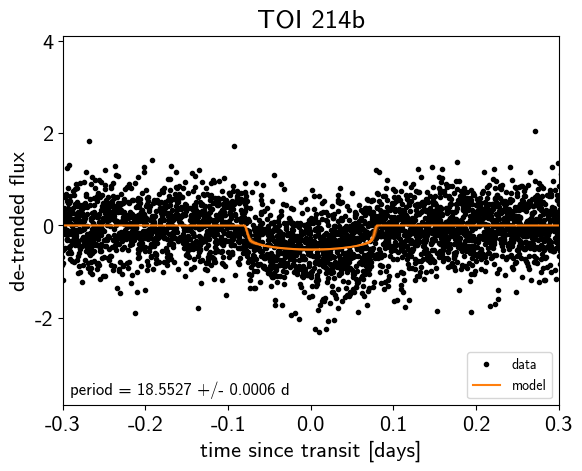

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we'll propagate the constraint on the radius ratio to a constraint on the physical radius of the planet using the stellar radius constraint from the TOI list (if provided).
We also plot the impact parameter constraints on this plot (remember that we're using circular orbits).

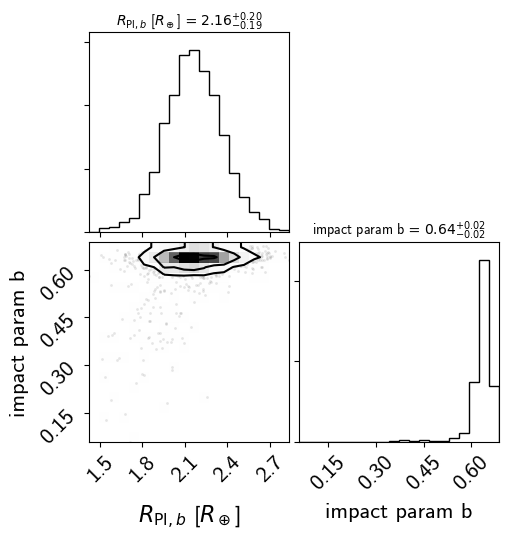

In [11]:
ror_samps = trace["r"]
r_star_samps = toi_r_star + toi_r_star_err * np.random.randn(len(ror_samps))
r_pl = ror_samps * r_star_samps[:, None] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

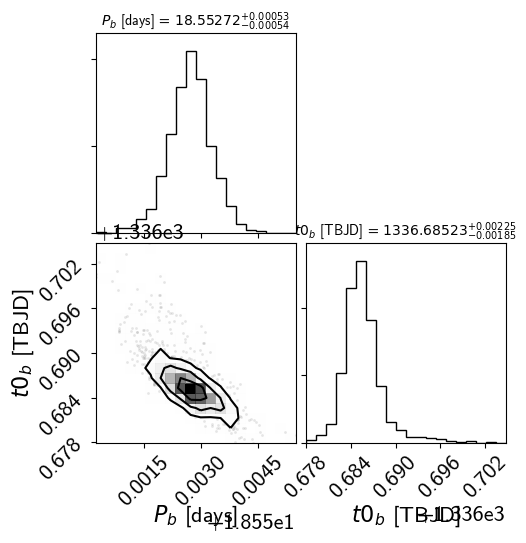

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [13]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [14]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke